In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler,PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

/Users/claudiadahinten/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
df = pd.read_csv('Earthwatch_Data/df_modelling.csv')

In [3]:
df.columns

Index(['sample_date', 'site_name', 'fw_bodytype', 'land_use', 'water_flow',
       'water_level', 'nitrate', 'phosphate', 'latitude', 'longitude',
       'precipIntensityMax', 'continent', 'country', 'state', 'county', 'city',
       'town', 'village', 'city_proxy', 'town_proxy', 'village_proxy',
       'other_proxy', 'water_body_category', 'year', 'month', 'quarter',
       'algae_evenly', 'algae_attached', 'algae_floating', 'algae_scum',
       'algae_noalg', 'aqlife_frogs', 'aqlife_fish', 'aqlife_other',
       'aqlife_plantsemerge', 'aqlife_none', 'aqlife_plantsbelow',
       'aqlife_birds', 'aqlife_plantsfloat', 'watuse_swimming', 'watuse_other',
       'watuse_watersupply', 'watuse_irrigation', 'watuse_fishing',
       'watuse_boating', 'pol_industrial', 'pol_other', 'pol_residential',
       'pol_road', 'watsur_oily', 'watsur_litter', 'watsur_foam',
       'watsur_none', 'watsur_floatalg', 'bankveg_noveg', 'bankveg_trees',
       'bankveg_other', 'bankveg_grass'],
      dtype='o

In [4]:
#drop columns that are not relevant in modelling
df.drop(columns=['sample_date', 'site_name', 'latitude', 'longitude', 'country', 'state', 'county',
                'city', 'town', 'village', 'nitrate', 'year'], inplace = True)

In [5]:
#convert month and quarter into object as they are not neccesarily in order
df.month = df.month.astype(str)
df.quarter = df.quarter.astype(str)

In [6]:
df_dummies = pd.get_dummies(df, drop_first = True)

In [7]:
df_dummies.shape

(16037, 80)

## Classification Models

### Phosphate target and predictor variables

In [8]:
#create classification for nitrate (low, medium, high)
df['classify_phosphate'] = df.phosphate.apply(lambda x: 'low' if x < 0.05 else \
                                                  'medium' if (x >= 0.05 and x < 0.1) \
                                                  else 'high'
                                                 )

In [9]:
#skewed dataset - most observations are low
df['classify_phosphate'].value_counts()

low       10242
high       3720
medium     2075
Name: classify_phosphate, dtype: int64

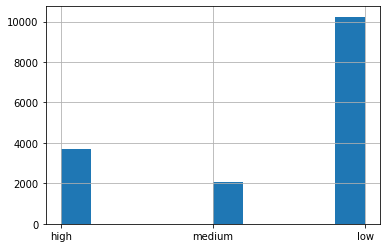

In [10]:
fig, ax = plt.subplots()
df.classify_phosphate.hist(ax = ax)
ax.set_x_ticklabels = (df,['low','medium','high'])
labels = ("low", "medium", "high");

In [11]:
# predictors without nitrate
X_pho = df_dummies.drop(columns = ['phosphate'])

In [12]:
# target
y_pho = df['classify_phosphate']

In [13]:
#baseline
y_pho.value_counts(normalize = True)

low       0.638648
high      0.231964
medium    0.129388
Name: classify_phosphate, dtype: float64

### Preprocessing

In [14]:
scaler = StandardScaler()
minmax = MinMaxScaler()
poly = PolynomialFeatures(2, interaction_only = True)

## MODELS

- Try different preprocessing steps on various untuned models.
- There are very slight differences between Bagging and Random Forest, and choosing different random states gives different best models.
- Polynomial Features gives the best results, but takes too long to run, so I will not choose this as the preferred model
- I will choose <b> Bagging with MinMax Scaler 69.2% </b> as the best model to tune

 

### No Standardisation

In [15]:
def scoring(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, 
                                                        stratify = y, random_state = 1 )
    
    fitted_model = model.fit(X_train, y_train)
    train = np.round(model.score(X_train, y_train), 3)
    test =  np.round(model.score(X_test, y_test), 3)
    cv = np.round(cross_val_score(model, X_train, y_train, cv = 5, n_jobs = 2).mean(), 3)
    
    return train, test, cv

In [16]:
models = {  

    'K-nearest': KNeighborsClassifier(),
    'Logistic': LogisticRegression(random_state = 1, solver = 'lbfgs', multi_class = 'auto', max_iter = 5000),
    'DecisionTree' : DecisionTreeClassifier(random_state=1, max_depth = 15),
    'RandomForest': RandomForestClassifier(random_state = 1, n_estimators = 100, max_depth = 15),
    'Bagging': BaggingClassifier(random_state=1, n_estimators = 100),
    'AdaBoost': AdaBoostClassifier(random_state=1, n_estimators = 100),
    'GradBoost': GradientBoostingClassifier(random_state=1, n_estimators = 100),
}

initial_results = { k: scoring(X_pho, y_pho, v) for k, v in models.items() }

In [17]:
no_scaler = pd.DataFrame(initial_results).T.rename(columns = {0 : 'Train',
                                                              1 : 'Test',
                                                              2 : 'CV'})

In [18]:
no_scaler

,Train,Test,CV
K-nearest,0.740,0.648,0.631
Logistic,0.651,0.648,0.649
DecisionTree,0.815,0.624,0.618
RandomForest,0.817,0.688,0.681
Bagging,0.995,0.695,0.691
AdaBoost,0.650,0.647,0.645
GradBoost,0.672,0.666,0.664


### Standard Scaler

In [19]:
def scoring_scaler(X, y, scaler, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True,
                                                        stratify = y, random_state = 1)
    
    pipe = Pipeline(steps = [('scaler', scaler), ('model', model)])
    
    fitted_model = pipe.fit(X_train, y_train)
    train = np.round(fitted_model.score(X_train, y_train), 3)
    test =  np.round(fitted_model.score(X_test, y_test), 3)
    cv = np.round(cross_val_score(fitted_model, X_train, y_train, cv = 5, n_jobs = 2).mean(), 3)
    
    return train, test, cv

In [20]:
initial_results = { k: scoring_scaler(X_pho, y_pho, scaler, v) for k, v in models.items() }

In [21]:
standard_scaler = pd.DataFrame(initial_results).T.rename(columns = {0 : 'Train',
                                                                    1 : 'Test',
                                                                    2 : 'CV'})

In [22]:
standard_scaler

,Train,Test,CV
K-nearest,0.736,0.635,0.625
Logistic,0.652,0.648,0.649
DecisionTree,0.815,0.624,0.618
RandomForest,0.817,0.688,0.681
Bagging,0.995,0.695,0.691
AdaBoost,0.650,0.647,0.645
GradBoost,0.672,0.666,0.664


### Min Max

In [23]:
initial_results = { k: scoring_scaler(X_pho, y_pho, minmax, v) for k, v in models.items() }

In [24]:
minmax_scaler = pd.DataFrame(initial_results).T.rename(columns = {0 : 'Train',
                                                                  1 : 'Test',
                                                                  2 : 'CV'})

In [25]:
minmax_scaler

,Train,Test,CV
K-nearest,0.740,0.644,0.632
Logistic,0.651,0.648,0.649
DecisionTree,0.815,0.624,0.618
RandomForest,0.817,0.688,0.681
Bagging,0.995,0.695,0.691
AdaBoost,0.650,0.647,0.645
GradBoost,0.672,0.666,0.664


### Poly

## Best Model

In [26]:
#BaggingClassifier

### Gridsearch

In [27]:
best_model = BaggingClassifier(random_state=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_pho, y_pho, test_size = 0.2, shuffle = True,
                                                    stratify = y_pho, random_state = 1)
pipe = Pipeline(steps = [('scaler', minmax), ('model', best_model)])    

grid_param = {'model__n_estimators': [50, 100, 200, 500],
             'model__max_samples' : [0.5, 0.7, 1],
             }
grid = GridSearchCV(pipe, grid_param, cv = 5)
grid.fit(X_train, y_train)
print('Train score: ', grid.score(X_train, y_train))
print('Test score: ', grid.score(X_test, y_test))

#takes a long time to run
print('Cross val score: ', cross_val_score(grid, X_train, y_train, cv = 5).mean())

Train score:  0.9941538701379686
Test score:  0.7004364089775561
Cross val score:  0.6964682373663672


### Feature Importances

In [29]:
grid.classes_

array(['high', 'low', 'medium'], dtype=object)

In [30]:
feature_importances = np.mean([tree.feature_importances_ for tree in 
                               grid.best_estimator_.named_steps['model'].estimators_], axis=0)
pd.DataFrame({'features' : X_pho.columns,
              'importances' : feature_importances}).sort_values('importances', ascending = False)[:20]

,features,importances
0,precipIntensityMax,0.062451
55,water_level_Low,0.024516
48,water_flow_Steady,0.022601
27,pol_road,0.022192
36,bankveg_grass,0.021949
47,land_use_Urban Residential,0.021738
26,pol_residential,0.021415
16,aqlife_birds,0.020401
13,aqlife_plantsemerge,0.020237
15,aqlife_plantsbelow,0.018886


### Decision Tree Visualisation

Cannot visualise Random Forest decision tree, but can visualise one decision tree from the Random Forest

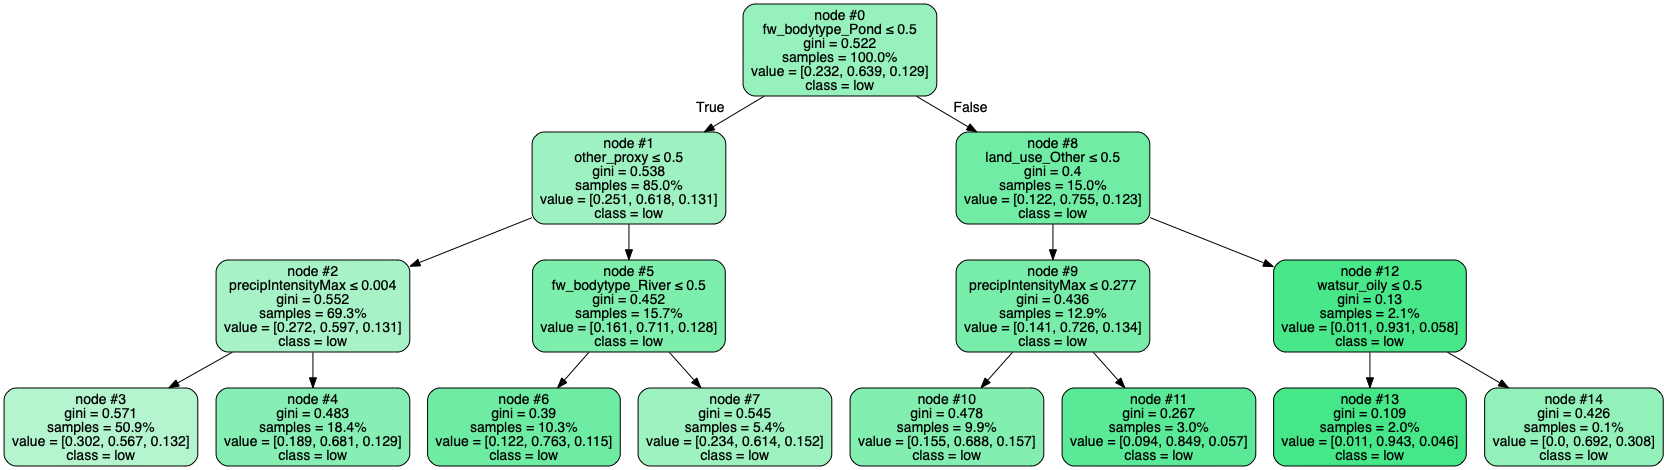

In [31]:
dt = DecisionTreeClassifier(
    max_depth=3, min_samples_split=2, random_state=1)
dt.fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,
                feature_names=X_pho.columns,  
                class_names=dt.classes_,
                filled=True, rounded=True,
                proportion=True,
                special_characters=True,
                node_ids=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Evaluation

In [32]:
def evaluation(model, X_train, y_train, X_test, y_test):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    print('Train Data')
    print('------------------------------------------------------------------------------------------------')
    conf_train = confusion_matrix(y_train, pred_train, labels = labels)
    print(pd.DataFrame(conf_train,columns = labels,index = labels))
    print(classification_report(y_train, pred_train, labels = labels))
    
    print('Test Data')
    print('------------------------------------------------------------------------------------------------')
    conf_test = confusion_matrix(y_test, pred_test, labels = labels)
    print(pd.DataFrame(conf_test,columns = labels,index = labels))
    print(classification_report(y_test, pred_test, labels = labels))

In [33]:
evaluation(grid, X_train, y_train, X_test, y_test)

Train Data
------------------------------------------------------------------------------------------------
         low  medium  high
low     8174       6    13
medium    30    1619    11
high      12       3  2961
              precision    recall  f1-score   support

         low       0.99      1.00      1.00      8193
      medium       0.99      0.98      0.98      1660
        high       0.99      0.99      0.99      2976

    accuracy                           0.99     12829
   macro avg       0.99      0.99      0.99     12829
weighted avg       0.99      0.99      0.99     12829

Test Data
------------------------------------------------------------------------------------------------
         low  medium  high
low     1899      29   121
medium   308      51    56
high     432      15   297
              precision    recall  f1-score   support

         low       0.72      0.93      0.81      2049
      medium       0.54      0.12      0.20       415
        high       0.63  

## Visualisation

### Set up Logistic Regression

The below investigates the most important features for the Logisitc Regression model.

In [34]:
model = LogisticRegression(random_state = 1, solver = 'lbfgs', multi_class = 'auto', max_iter = 5000)
X_train, X_test, y_train, y_test = train_test_split(X_pho, y_pho, test_size = 0.2, shuffle = True,
                                                    stratify = y_pho, random_state = 1)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
model.classes_

array(['high', 'low', 'medium'], dtype=object)

### Coefficients

In [36]:
#coefficients for high nitrate levels
coef_df = pd.DataFrame({'features': X_pho.columns,
                        'coef': model.coef_[0],
                        'abs_coef': np.abs(model.coef_[0])})

coef_df.sort_values('abs_coef', ascending = False)[:10]

,features,coef,abs_coef
53,water_level_Height,0.992844,0.992844
38,fw_bodytype_Pond,-0.769302,0.769302
52,water_level_Center,-0.565016,0.565016
4,other_proxy,-0.457803,0.457803
58,continent_Asia,0.421004,0.421004
42,land_use_Forest,-0.415045,0.415045
62,continent_South America,0.365414,0.365414
45,land_use_Other,-0.319038,0.319038
66,month_11.0,0.309247,0.309247
59,continent_Europe,0.273090,0.273090


### ROC Curve

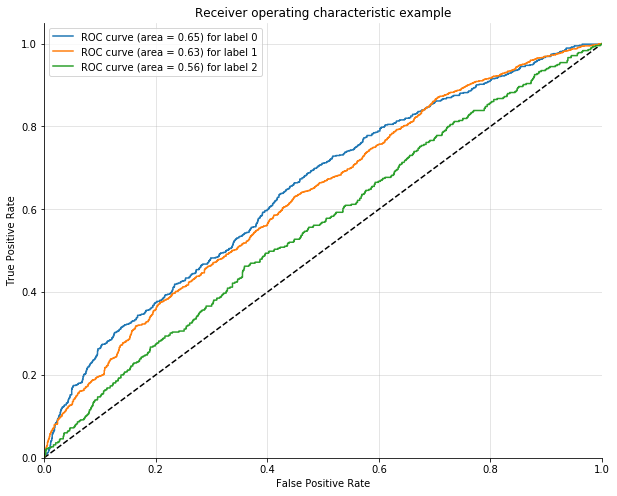

In [37]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(model, X_test, y_test, n_classes=3, figsize=(10, 8))